# Post Regrid Data Handling

Goal is to have a streamlined way to access the files a user needs given a set of parameters. Envisioning something where a user could enter:
* Sectors of interest (or "all")
* Timerange of interest
* Spatial bounding box
* Gas species of interest    

And be returned either an xarray object with dask parallelization, or create a new netCDF/set of netCDF files to be loaded by the user later. 

There is obviously lots of work to be done, but this is a good start if you want to start playing with data. 


In [10]:
import xarray as xr
import pandas as pd
import os
import pyproj
import numpy as np
import xesmf as xe
import calendar
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

import noaa_csl_funcs as ncf

In [11]:
# map_extent={'lon_min':-112.25,
#             'lon_max':-111.55,
#             'lat_min':40.3,
#             'lat_max':41.1} 
# dataset_extent = {'lon_min':-112.15,
#                   'lon_max':-111.7,
#                   'lat_min':40.4,
#                   'lat_max':41.0} 

map_extent={'lon_min':-112.4,
            'lon_max':-111.4,
            'lat_min':40.1,
            'lat_max':41.3} 
dataset_extent = {'lon_min':-112.25,
                  'lon_max':-111.6,
                  'lat_min':40.3,
                  'lat_max':41.1} 

In [12]:
regridded_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded2'
RCH = ncf.Regridded_CSL_Handler(regridded_path)
dt1  = pd.to_datetime('2019-01-01 00') 
dt2 = pd.to_datetime('2019-02-28 23') 
day_types = ['weekdy','satdy','sundy'] #a list with any or all of 'weekdy','satdy','sundy'
species = ['HC01','CO2','CO']

save_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/NC'
save_prefix = 'slc_2019_em27'

In [13]:
sector_types = ['area','point']
combined_dss = {}
for sector_type in sector_types:
    #Get the paths to the files that match the criteria
    days_paths = RCH.get_days_in_range(dt1,dt2,day_types,sector_type) 
    files = RCH.get_files_in_days(days_paths)

    load_vars = [] #the variables we want to load
    if sector_type == 'area': #for area sources, just load the species defined above
        load_vars = species.copy() 
    if sector_type == 'point': #for point, often useful to have the stack/type information 
        load_vars = species.copy()
        load_vars.extend(['ITYPE','STKht','STKdiam','STKtemp','STKve','STKflw','FUGht']) #so add it to the actual species

    #Load the files with xarray, preprocessing them so they can be combined by coordinates
    ds_list = [] #initialize the list of datasets
    for file in files:
        ds = RCH.preprocess_regridded(xr.open_dataset(file,chunks = {'utc_hour':1}),dataset_extent)[load_vars] #prepreprocess the file, open with dask chunking, and only keep the species of interest
        ds_list.append(ds)  
    ds_combined = xr.combine_by_coords(ds_list,combine_attrs='drop_conflicts') #this is the combined dataset!
    combined_dss[sector_type] = ds_combined

In [34]:
#Save to nc
for sector_type in sector_types:
    combined_dss[sector_type].to_netcdf(os.path.join(save_path,f"{save_prefix}_{sector_type}.nc"))

Now we can start to play with subsetting and representing data. 

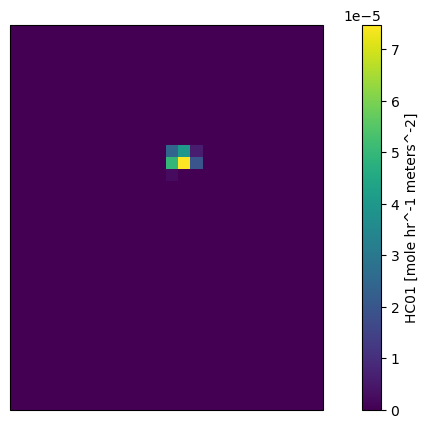

In [15]:
# For example:
# This is the mean daily emission rate of CO2 from onroad_gasoline on a weekday in Jan 2019 for the whole US
spec = 'HC01'
plotds = combined_dss['area'][spec].sel(sector='area_OG',
                         day_type='weekdy',
                         yr_mo='2019-1'
                         ).mean(dim='utc_hour',keep_attrs=True)

#Plotting
proj = ccrs.PlateCarree() #set the projection
fig = plt.figure(figsize=(10,5)) #setup the figure
ax = plt.axes(projection = proj) #setup the axis with correct projection
plotds.plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis') #plot the dataset on the ax 
ax.coastlines() #add coastlines
ax.add_feature(cfeature.BORDERS) #borders 
ax.add_feature(cfeature.STATES) #states
plt.title('')
plt.show() #show it

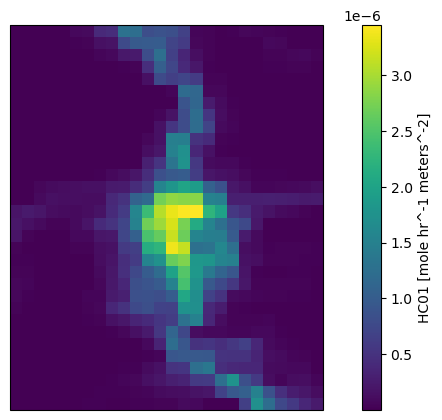

In [16]:
#This is the mean daily emission rate of methane (HC01) from industry on a saturday in Febuary 2019 near northern Utah
# TODO This can take a long time. Find the bottleneck. Suspect it is the lat lon slicing? why tho...

# map_extent={'lon_low':-115.4,
#             'lon_high':-109.6,
#             'lat_low':38.5,
#             'lat_high':45.0} #define the extent

plotds = combined_dss['area'].sel(sector='area_onroad_gasoline',day_type='satdy',yr_mo='2019-2', #sector day type and month
                         lat=slice(map_extent['lat_min'],map_extent['lat_max']), 
                         lon=slice(map_extent['lon_min'],map_extent['lon_max']) #subselect the bounding box in lat lon
                         )['HC01'].mean(dim='utc_hour',keep_attrs = True) #take methane (HC01) and the mean hourly

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection = proj)
plotds.plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.title('')
plt.show()